In [3]:
import sys

import os
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath('../src'))

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('../src/save/ER_intermediate_stdp/0/metrics.csv')

In [6]:
df

,batch,emsrs_h_A,emsrs_h_B,emsrs_h_C,emsrs_h_A_T,emsrs_h_B_T,emsrs_h_C_T,emsrs_mi_AB,emsrs_mi_AC,emsrs_mi_AA,emsrs_mi_AB_T,emsrs_mi_AC_T,emsrs_mi_AA_T,lz_avg_lz_pre,lz_avg_lz_post_init,lz_avg_lz_post_final,drf_batch_driver_fraction
0,0,9.986673,9.866481,9.925741,8.209193,8.209193,8.209193,7.951605,7.980980,9.986673,8.209193,8.209193,8.209193,0.075249,0.073766,0.074125,0.045513
1,1,9.925065,9.851162,9.799295,8.209193,8.209193,8.209193,7.895516,7.839253,9.925065,8.209193,8.209193,8.209193,0.074436,0.072905,0.073049,0.043020
2,2,9.694172,9.643306,9.537014,8.209193,8.209193,8.209193,7.483366,7.367500,9.694172,8.209193,8.209193,8.209193,0.072642,0.071159,0.071398,0.043230
3,3,9.803197,9.737574,9.775960,8.209193,8.209193,8.209193,7.674562,7.740556,9.803197,8.209193,8.209193,8.209193,0.073838,0.072116,0.072570,0.044084
4,4,9.828635,9.729563,9.798812,8.209193,8.209193,8.209193,7.686967,7.740736,9.828635,8.209193,8.209193,8.209193,0.073910,0.073097,0.073623,0.045250
5,5,9.960211,9.958433,9.918735,8.209193,8.209193,8.209193,8.025169,7.956048,9.960211,8.209193,8.209193,8.209193,0.075393,0.074221,0.074603,0.045758
6,6,9.926838,9.802696,9.801215,8.209193,8.209193,8.209193,7.831328,7.855041,9.926838,8.209193,8.209193,8.209193,0.075297,0.073982,0.073838,0.045675
7,7,9.924717,9.762794,9.752325,8.209193,8.209193,8.209193,7.805547,7.810674,9.924717,8.209193,8.209193,8.209193,0.074627,0.073264,0.073599,0.046139
8,8,9.895890,9.832220,9.766655,8.209193,8.209193,8.209193,7.844474,7.749154,9.895890,8.209193,8.209193,8.209193,0.074938,0.073982,0.073623,0.044930
9,9,9.905618,9.588014,9.664542,8.209193,8.209193,8.209193,7.620236,7.677953,9.905618,8.209193,8.209193,8.209193,0.074460,0.073360,0.073120,0.044800


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_entropy_stability(df, plot=True):
    """
    Analyze the stability of entropy measurements across different attack phases.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing entropy measurements
    plot (bool): Whether to generate plots
    
    Returns:
    dict: Dictionary containing stability metrics
    """
    # Extract entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    
    # Calculate basic statistics for each phase
    stats = {}
    for name, series in [('pre_attack', entropy_pre), 
                         ('post_immediate', entropy_post_immediate), 
                         ('post_late', entropy_post_late)]:
        stats[name] = {
            'mean': series.mean(),
            'min': series.min(),
            'max': series.max(),
            'range': series.max() - series.min(),
            'std': series.std(),
            'cv': series.std() / series.mean() * 100  # Coefficient of Variation in percentage
        }
    
    # Calculate changes between phases
    changes = {
        'impact_immediate': np.abs(entropy_post_immediate - entropy_pre).mean(),  # A to B
        'recovery': np.abs(entropy_post_late - entropy_post_immediate).mean(),    # B to C
        'overall_impact': np.abs(entropy_post_late - entropy_pre).mean(),         # A to C
        'percent_change_overall': np.abs((entropy_post_late - entropy_pre) / entropy_pre * 100).mean()
    }
    
    # Determine if entropy is stable based on coefficient of variation threshold
    stability_threshold = 5.0  # 5% CV is considered stable
    is_stable = all(stats[phase]['cv'] < stability_threshold for phase in stats)
    
    if plot:
        # Create visualization to help interpret stability
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Entropy values across attacks
        plt.subplot(2, 2, 1)
        plt.plot(df['batch'], entropy_pre, 'o-', label='Pre-attack')
        plt.plot(df['batch'], entropy_post_immediate, 'o-', label='Post-immediate')
        plt.plot(df['batch'], entropy_post_late, 'o-', label='Post-late')
        plt.title('Entropy Values Across 10 Attacks')
        plt.xlabel('Attack Number')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Coefficient of variation
        plt.subplot(2, 2, 2)
        phases = ['Pre-attack', 'Post-immediate', 'Post-late']
        cv_values = [stats['pre_attack']['cv'], 
                     stats['post_immediate']['cv'], 
                     stats['post_late']['cv']]
        plt.bar(phases, cv_values)
        plt.axhline(y=stability_threshold, color='r', linestyle='--', 
                   label=f'Stability Threshold ({stability_threshold}%)')
        plt.title('Coefficient of Variation by Phase')
        plt.ylabel('CV (%)')
        plt.legend()
        
        # Plot 3: Boxplot of entropy values
        plt.subplot(2, 2, 3)
        entropy_data = pd.DataFrame({
            'Pre-attack': entropy_pre,
            'Post-immediate': entropy_post_immediate,
            'Post-late': entropy_post_late
        })
        sns.boxplot(data=entropy_data)
        plt.title('Distribution of Entropy Values')
        plt.ylabel('Entropy')
        
        plt.tight_layout()
        plt.show()
    
    return {**stats, 'changes': changes, 'is_stable': is_stable}

# Example usage with dataframe:
# df = pd.read_csv('metrics.csv')
# results = analyze_entropy_stability(df)
# print(f"Is the entropy stable against random attacks? {'Yes' if results['is_stable'] else 'No'}")



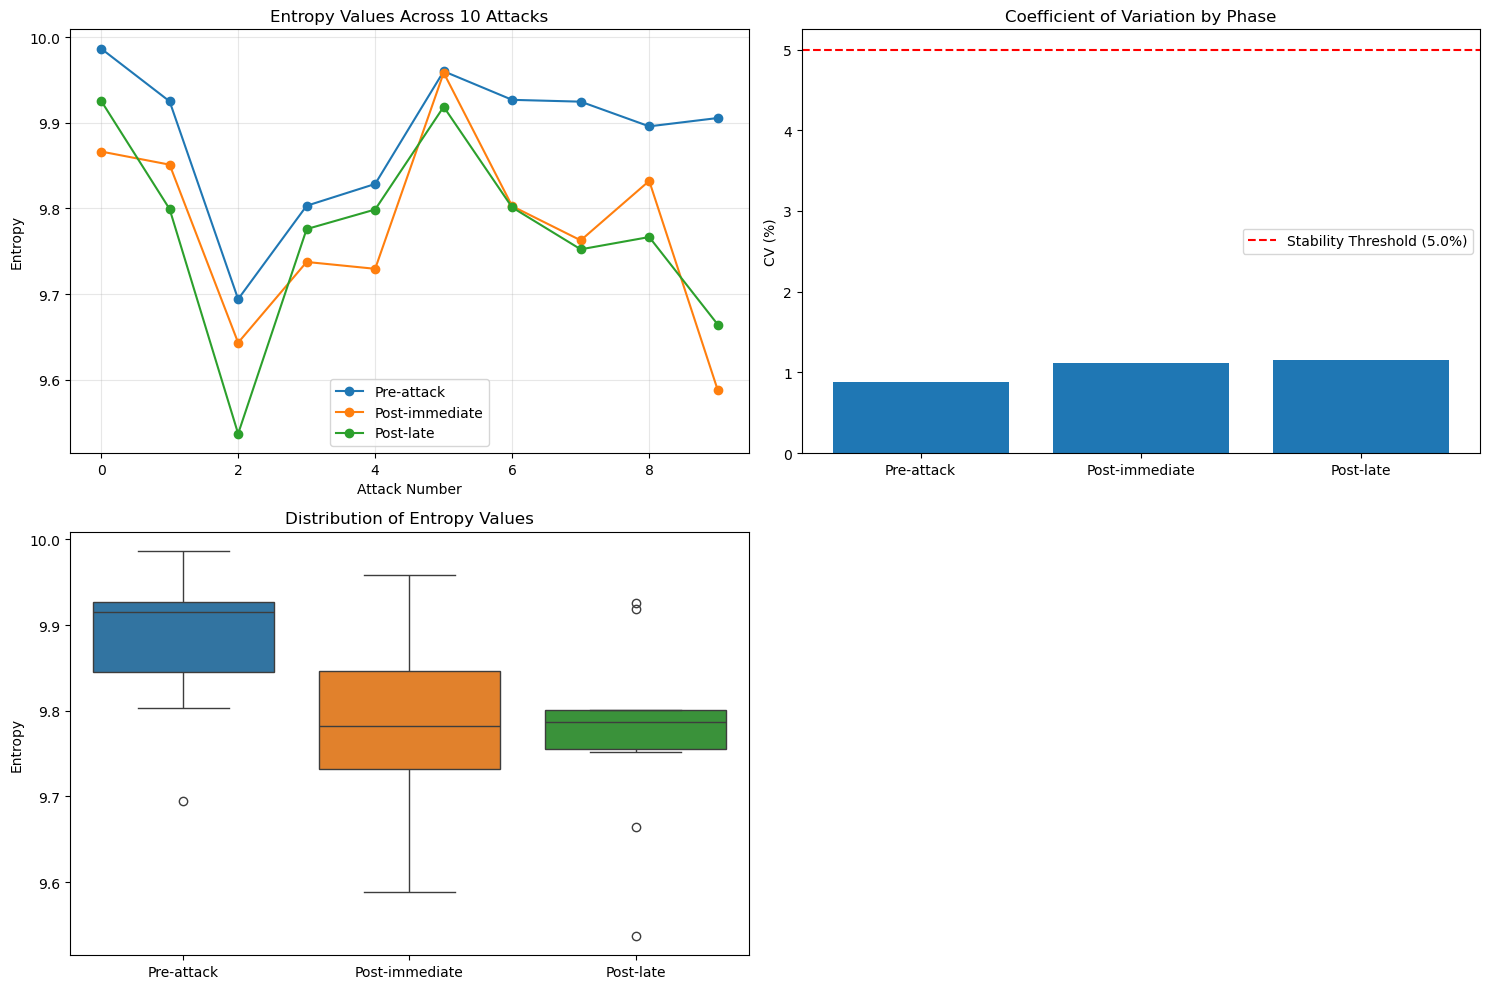

{'pre_attack': {'mean': np.float64(9.885101573175145),
  'min': np.float64(9.694172325780018),
  'max': np.float64(9.986672962119608),
  'range': np.float64(0.29250063633958945),
  'std': np.float64(0.08676581132471514),
  'cv': np.float64(0.8777432450483714)},
 'post_immediate': {'mean': np.float64(9.777224230309933),
  'min': np.float64(9.588013526032324),
  'max': np.float64(9.958432766517635),
  'range': np.float64(0.3704192404853117),
  'std': np.float64(0.10940753864483255),
  'cv': np.float64(1.1190040861051662)},
 'post_late': {'mean': np.float64(9.774029340992357),
  'min': np.float64(9.537014018495672),
  'max': np.float64(9.92574070896894),
  'range': np.float64(0.388726690473268),
  'std': np.float64(0.11286197776146238),
  'cv': np.float64(1.1547129011381043)},
 'changes': {'impact_immediate': np.float64(0.10787734286521218),
  'recovery': np.float64(0.051879630883312086),
  'overall_impact': np.float64(0.11107223218278808),
  'percent_change_overall': np.float64(1.1238337

In [48]:
analyze_entropy_stability(df)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def advanced_entropy_stability(df):
    """
    Comprehensive analysis of entropy stability with statistical testing.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing entropy measurements
    
    Returns:
    dict: Dictionary containing stability metrics and statistical test results
    """
    # Extract entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    
    # Basic statistics for each phase
    basic_stats = analyze_entropy_stability(df, plot=False)
    
    # Statistical tests
    # 1. Repeated measures ANOVA (or Friedman test as non-parametric alternative)
    # Prepare data for the test
    entropy_data = np.vstack((entropy_pre, entropy_post_immediate, entropy_post_late)).T
    friedman_stat, friedman_p = stats.friedmanchisquare(entropy_pre, entropy_post_immediate, entropy_post_late)
    
    # 2. Wilcoxon signed-rank tests for paired comparisons
    wilcoxon_ab = stats.wilcoxon(entropy_pre, entropy_post_immediate)
    wilcoxon_bc = stats.wilcoxon(entropy_post_immediate, entropy_post_late)
    wilcoxon_ac = stats.wilcoxon(entropy_pre, entropy_post_late)
    
    # 3. Levene's test for homogeneity of variance
    levene_stat, levene_p = stats.levene(entropy_pre, entropy_post_immediate, entropy_post_late)
    
    # Calculate percentage of attacks where entropy returns close to original
    recovery_threshold = 0.01  # 1% threshold
    percent_recovered = (np.abs((entropy_post_late - entropy_pre) / entropy_pre) < recovery_threshold).mean() * 100
    
    # Combine all results
    statistical_tests = {
        'friedman_test': {
            'statistic': friedman_stat,
            'p_value': friedman_p,
            'significant': friedman_p < 0.05
        },
        'wilcoxon_pre_vs_immediate': {
            'statistic': wilcoxon_ab.statistic,
            'p_value': wilcoxon_ab.pvalue,
            'significant': wilcoxon_ab.pvalue < 0.05
        },
        'wilcoxon_immediate_vs_late': {
            'statistic': wilcoxon_bc.statistic,
            'p_value': wilcoxon_bc.pvalue,
            'significant': wilcoxon_bc.pvalue < 0.05
        },
        'wilcoxon_pre_vs_late': {
            'statistic': wilcoxon_ac.statistic,
            'p_value': wilcoxon_ac.pvalue,
            'significant': wilcoxon_ac.pvalue < 0.05
        },
        'levene_test': {
            'statistic': levene_stat,
            'p_value': levene_p,
            'significant': levene_p < 0.05
        },
        'percent_recovered_within_threshold': percent_recovered
    }
    
    # Determine overall stability from multiple criteria
    criteria_met = [
        basic_stats['is_stable'],  # CV-based stability
        not statistical_tests['levene_test']['significant'],  # No significant difference in variances
        percent_recovered >= 50  # At least half of cases recover within threshold
    ]
    
    stability_score = sum(criteria_met) / len(criteria_met) * 100
    
    return {**basic_stats, 'statistical_tests': statistical_tests, 'stability_score': stability_score}


In [7]:
advanced_entropy_stability(df)

NameError: name 'advanced_entropy_stability' is not defined

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_advanced_metrics(df):
    """
    Calculate advanced metrics for entropy and mutual information,
    including gain, loss, and recovery ratios.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing entropy and mutual information measurements
    
    Returns:
    dict: Dictionary containing calculated metrics and statistics
    """
    # Extract entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    
    # Extract mutual information columns
    mi_AB = df['emsrs_mi_AB']  # Mutual information between pre and immediate post
    mi_AC = df['emsrs_mi_AC']  # Mutual information between pre and late post
    mi_AA = df['emsrs_mi_AA']  # Mutual information pre with itself (typically equal to entropy_pre)
    
    # Calculate the requested metrics for entropy (H)
    G_H = entropy_post_late - entropy_post_immediate  # Gain in entropy from immediate to late
    L_H = entropy_pre - entropy_post_immediate        # Loss in entropy due to attack
    
    # Handle division by zero for R_H calculation
    R_H = np.zeros_like(G_H)
    for i in range(len(G_H)):
        if L_H[i] != 0:
            R_H[i] = G_H[i] / L_H[i]
        else:
            R_H[i] = np.nan  # Set to NaN if L_H is zero
    
    # Calculate the requested metrics for mutual information (mi)
    G_mi = mi_AC - mi_AB  # Gain in mutual information from immediate to late
    L_mi = mi_AA - mi_AB  # Loss in mutual information due to attack
    
    # Handle division by zero for R_mi calculation
    R_mi = np.zeros_like(G_mi)
    for i in range(len(G_mi)):
        if L_mi[i] != 0:
            R_mi[i] = G_mi[i] / L_mi[i]
        else:
            R_mi[i] = np.nan  # Set to NaN if L_mi is zero
    
    # Calculate basic statistics for all metrics
    metrics = {
        # Entropy metrics
        'G_H': calculate_basic_stats(G_H, 'G_H'),
        'L_H': calculate_basic_stats(L_H, 'L_H'),
        'R_H': calculate_basic_stats(R_H, 'R_H'),
        
        # Mutual information metrics
        'G_mi': calculate_basic_stats(G_mi, 'G_mi'),
        'L_mi': calculate_basic_stats(L_mi, 'L_mi'),
        'R_mi': calculate_basic_stats(R_mi, 'R_mi')
    }
    
    # Add the raw data for reference
    raw_data = {
        'G_H': G_H,
        'L_H': L_H,
        'R_H': R_H,
        'G_mi': G_mi,
        'L_mi': L_mi,
        'R_mi': R_mi
    }
    
    return {'metrics': metrics, 'raw_data': raw_data}

def calculate_basic_stats(series, name):
    """Calculate basic statistics for a data series"""
    # Handle potential NaN values
    clean_series = series[~np.isnan(series)]
    
    return {
        'name': name,
        'mean': np.mean(clean_series),
        'median': np.median(clean_series),
        'std': np.std(clean_series),
        'min': np.min(clean_series),
        'max': np.max(clean_series),
        'range': np.max(clean_series) - np.min(clean_series),
        'cv': (np.std(clean_series) / np.mean(clean_series) * 100) if np.mean(clean_series) != 0 else float('inf')
    }

# Example usage:
# df = pd.read_csv('metrics.csv')
# results = calculate_advanced_metrics(df)
# 
# # Print the results
# for metric_name, stats in results['metrics'].items():
#     print(f"\n{metric_name} Statistics:")
#     print(f"  Mean: {stats['mean']:.6f}")
#     print(f"  Median: {stats['median']:.6f}")
#     print(f"  Std Dev: {stats['std']:.6f}")
#     print(f"  Range: [{stats['min']:.6f}, {stats['max']:.6f}]")
#     print(f"  CV: {stats['cv']:.2f}%")


In [9]:
results = calculate_advanced_metrics(df)
results

{'metrics': {'G_H': {'name': 'G_H',
   'mean': np.float64(-0.0031948893175759),
   'median': np.float64(-0.005975322716055054),
   'std': np.float64(0.059590240151359636),
   'min': np.float64(-0.10629238522010453),
   'max': np.float64(0.07652895330589082),
   'range': np.float64(0.18282133852599536),
   'cv': np.float64(-1865.173851987252)},
  'L_H': {'name': 'L_H',
   'mean': np.float64(0.10787734286521218),
   'median': np.float64(0.08648757231550519),
   'std': np.float64(0.08173212025784667),
   'min': np.float64(0.0017780888825971175),
   'max': np.float64(0.31760444495452766),
   'range': np.float64(0.31582635607193055),
   'cv': np.float64(75.76393530564359)},
  'R_H': {'name': 'R_H',
   'mean': np.float64(-2.420612744233539),
   'median': np.float64(-0.038294348727576255),
   'std': np.float64(6.685224882764947),
   'min': np.float64(-22.326220999506965),
   'max': np.float64(0.6989763896385446),
   'range': np.float64(23.02519738914551),
   'cv': np.float64(-276.179033539780

/var/folders/g8/nl718mjj3q32_ynwvrcqd2wh0000gn/T/ipykernel_30797/2862970140.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(metrics, labels=labels)


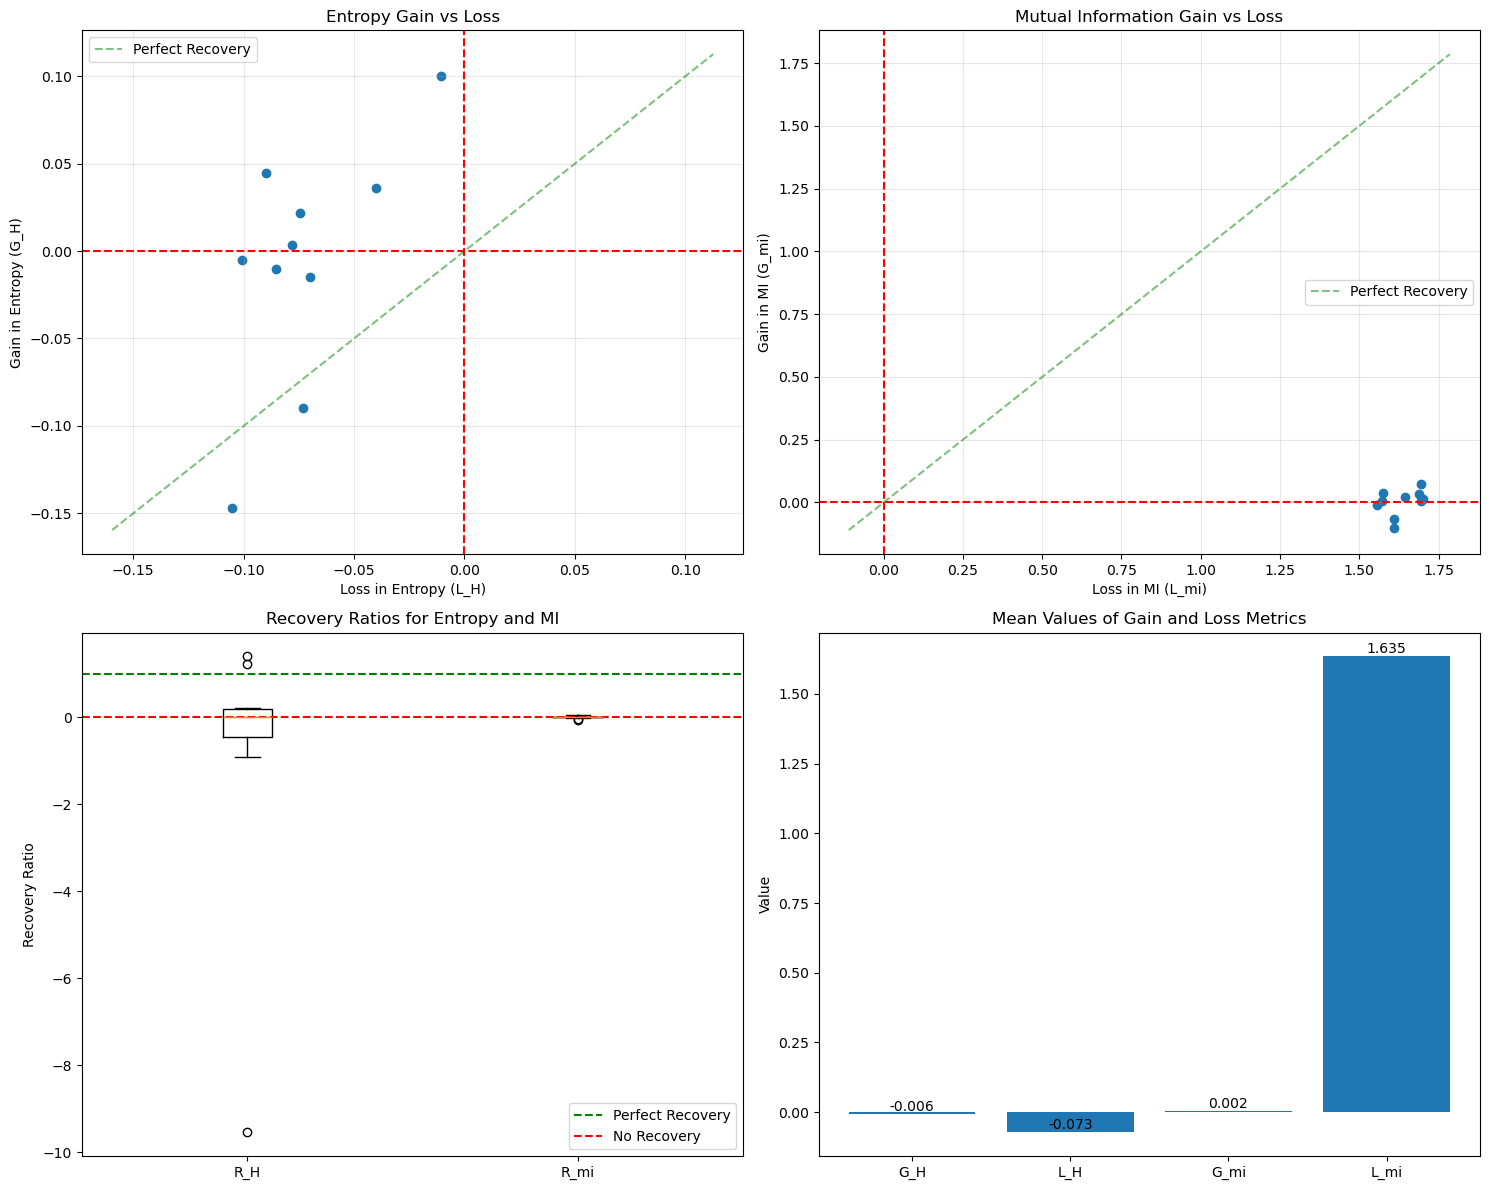

In [44]:
visualize_advanced_metrics(results)

In [50]:
import numpy as np
from sklearn.utils import resample

def bootstrap_recovery_ratios(R_H, R_mi, n_bootstrap=10000, confidence=0.95):
    """
    Perform bootstrap analysis on recovery ratios
    
    Parameters:
    R_H (array-like): Entropy recovery ratio values
    R_mi (array-like): Mutual information recovery ratio values
    n_bootstrap (int): Number of bootstrap samples
    confidence (float): Confidence level
    
    Returns:
    dict: Dictionary with bootstrap results
    """
    # Clean data by removing NaN values
    R_H_clean = np.array(R_H)[~np.isnan(R_H)]
    R_mi_clean = np.array(R_mi)[~np.isnan(R_mi)]
    
    # Bootstrap for R_H
    bootstrap_means_H = []
    for i in range(n_bootstrap):
        boot_sample = resample(R_H_clean, replace=True, n_samples=len(R_H_clean))
        bootstrap_means_H.append(np.mean(boot_sample))
    
    # Bootstrap for R_mi
    bootstrap_means_mi = []
    for i in range(n_bootstrap):
        boot_sample = resample(R_mi_clean, replace=True, n_samples=len(R_mi_clean))
        bootstrap_means_mi.append(np.mean(boot_sample))
    
    # Calculate confidence intervals
    alpha = (1 - confidence) / 2
    H_ci = (np.percentile(bootstrap_means_H, 100 * alpha),
            np.percentile(bootstrap_means_H, 100 * (1 - alpha)))
    
    mi_ci = (np.percentile(bootstrap_means_mi, 100 * alpha),
             np.percentile(bootstrap_means_mi, 100 * (1 - alpha)))
    
    return {
        'R_H_bootstrap': {'mean': np.mean(R_H_clean), 'ci': H_ci},
        'R_mi_bootstrap': {'mean': np.mean(R_mi_clean), 'ci': mi_ci}
    }


In [51]:
import numpy as np
import scipy.stats as stats

def test_recovery_stability(R_H, R_mi):
    """
    Test the stability of recovery ratios across attacks
    
    Parameters:
    R_H (array-like): Entropy recovery ratio values
    R_mi (array-like): Mutual information recovery ratio values
    
    Returns:
    dict: Dictionary with stability metrics
    """
    # Calculate coefficient of variation
    R_H_clean = np.array(R_H)[~np.isnan(R_H)]
    R_mi_clean = np.array(R_mi)[~np.isnan(R_mi)]
    
    R_H_cv = np.std(R_H_clean) / np.mean(R_H_clean) * 100 if np.mean(R_H_clean) != 0 else float('inf')
    R_mi_cv = np.std(R_mi_clean) / np.mean(R_mi_clean) * 100 if np.mean(R_mi_clean) != 0 else float('inf')
    
    # Calculate interquartile range
    R_H_iqr = stats.iqr(R_H_clean)
    R_mi_iqr = stats.iqr(R_mi_clean)
    
    # Calculate median absolute deviation
    R_H_mad = stats.median_abs_deviation(R_H_clean)
    R_mi_mad = stats.median_abs_deviation(R_mi_clean)
    
    return {
        'R_H_stability': {'cv': R_H_cv, 'iqr': R_H_iqr, 'mad': R_H_mad},
        'R_mi_stability': {'cv': R_mi_cv, 'iqr': R_mi_iqr, 'mad': R_mi_mad}
    }


In [ ]:
results["metrics"]

{'metrics': {'G_H': {'name': 'G_H',
   'mean': np.float64(-0.0031948893175759),
   'median': np.float64(-0.005975322716055054),
   'std': np.float64(0.059590240151359636),
   'min': np.float64(-0.10629238522010453),
   'max': np.float64(0.07652895330589082),
   'range': np.float64(0.18282133852599536),
   'cv': np.float64(-1865.173851987252)},
  'L_H': {'name': 'L_H',
   'mean': np.float64(0.10787734286521218),
   'median': np.float64(0.08648757231550519),
   'std': np.float64(0.08173212025784667),
   'min': np.float64(0.0017780888825971175),
   'max': np.float64(0.31760444495452766),
   'range': np.float64(0.31582635607193055),
   'cv': np.float64(75.76393530564359)},
  'R_H': {'name': 'R_H',
   'mean': np.float64(-2.420612744233539),
   'median': np.float64(-0.038294348727576255),
   'std': np.float64(6.685224882764947),
   'min': np.float64(-22.326220999506965),
   'max': np.float64(0.6989763896385446),
   'range': np.float64(23.02519738914551),
   'cv': np.float64(-276.179033539780

In [53]:
bootstrap_recovery_ratios(results["raw_data"]["R_H"], results["raw_data"]["R_mi"])

{'R_H_bootstrap': {'mean': np.float64(-2.420612744233539),
  'ci': (np.float64(-7.048621042839804), np.float64(0.17029263117178042))},
 'R_mi_bootstrap': {'mean': np.float64(-0.005278416927159123),
  'ci': (np.float64(-0.02461828897204911), np.float64(0.0132593774975527))}}

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

def bootstrap_analysis(data, n_bootstrap=10000, confidence=0.95):
    """
    Perform bootstrap analysis on a small sample
    
    Parameters:
    data (array-like): Sample data
    n_bootstrap (int): Number of bootstrap samples
    confidence (float): Confidence level
    
    Returns:
    dict: Dictionary with bootstrap results
    """
    # Clean data by removing NaN values
    clean_data = np.array(data)[~np.isnan(data)]
    
    # Original statistic (mean)
    orig_mean = np.mean(clean_data)
    
    # Bootstrap resampling
    bootstrap_means = []
    for i in range(n_bootstrap):
        boot_sample = resample(clean_data, replace=True, n_samples=len(clean_data))
        bootstrap_means.append(np.mean(boot_sample))
    
    # Calculate confidence intervals
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, 100 * alpha)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha))
    
    
    return {
        'mean': orig_mean,
        'confidence_interval': (ci_lower, ci_upper),
        'bootstrap_distribution': bootstrap_means,
        'contains_1': (ci_lower <= 1 <= ci_upper)
    }

def analyze_recovery_ratios(R_H, R_mi, plot=True):
    """
    Analyze recovery ratios using bootstrap
    """
    R_H_results = bootstrap_analysis(R_H)
    R_mi_results = bootstrap_analysis(R_mi)
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Plot for R_H
        plt.subplot(1, 2, 1)
        plt.hist(R_H_results['bootstrap_distribution'], bins=30, alpha=0.7)
        plt.axvline(x=R_H_results['mean'], color='g', label=f'Mean: {R_H_results["mean"]:.3f}')
        plt.axvline(x=1, color='r', linestyle='--', label='Perfect Recovery (1.0)')
        plt.axvline(x=R_H_results['confidence_interval'][0], color='b', linestyle=':',
                    label=f'95% CI: [{R_H_results["confidence_interval"][0]:.3f}, {R_H_results["confidence_interval"][1]:.3f}]')
        plt.axvline(x=R_H_results['confidence_interval'][1], color='b', linestyle=':')
        plt.title('Bootstrap Distribution for Entropy Recovery Ratio (R_H)')
        plt.legend(loc='best', fontsize=9)
        
        # Plot for R_mi
        plt.subplot(1, 2, 2)
        plt.hist(R_mi_results['bootstrap_distribution'], bins=30, alpha=0.7)
        plt.axvline(x=R_mi_results['mean'], color='g', label=f'Mean: {R_mi_results["mean"]:.3f}')
        plt.axvline(x=1, color='r', linestyle='--', label='Perfect Recovery (1.0)')
        plt.axvline(x=R_mi_results['confidence_interval'][0], color='b', linestyle=':',
                    label=f'95% CI: [{R_mi_results["confidence_interval"][0]:.3f}, {R_mi_results["confidence_interval"][1]:.3f}]')
        plt.axvline(x=R_mi_results['confidence_interval'][1], color='b', linestyle=':')
        plt.title('Bootstrap Distribution for Mutual Info Recovery Ratio (R_mi)')
        plt.legend(loc='best', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return {'R_H': R_H_results, 'R_mi': R_mi_results}


In [23]:
import pandas as pd
import numpy as np

# Assuming you have your data loaded in a DataFrame
def calculate_and_analyze_recovery_ratios(df):
    # Extract entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    
    # Extract mutual information columns
    mi_AB = df['emsrs_mi_AB']
    mi_AC = df['emsrs_mi_AC']
    mi_AA = df['emsrs_mi_AA']
    
    # Calculate the recovery ratios
    G_H = entropy_post_late - entropy_post_immediate  # Gain in entropy
    L_H = entropy_pre - entropy_post_immediate        # Loss in entropy
    R_H = G_H / L_H                                   # Recovery ratio for entropy
    
    G_mi = mi_AC - mi_AB                              # Gain in mutual information
    L_mi = mi_AA - mi_AB                              # Loss in mutual information
    R_mi = G_mi / L_mi                                # Recovery ratio for mutual information
    
    # Run bootstrap analysis
    bootstrap_results = analyze_recovery_ratios(R_H, R_mi, False)
    
    # print(f"Entropy Recovery Ratio (R_H):")
    # print(f"  Mean: {bootstrap_results['R_H']['mean']:.4f}")
    # print(f"  95% CI: [{bootstrap_results['R_H']['confidence_interval'][0]:.4f}, {bootstrap_results['R_H']['confidence_interval'][1]:.4f}]")
    # print(f"  CI contains 1.0: {bootstrap_results['R_H']['contains_1']}")
    
    # print(f"\nMutual Information Recovery Ratio (R_mi):")
    # print(f"  Mean: {bootstrap_results['R_mi']['mean']:.4f}")
    # print(f"  95% CI: [{bootstrap_results['R_mi']['confidence_interval'][0]:.4f}, {bootstrap_results['R_mi']['confidence_interval'][1]:.4f}]")
    # print(f"  CI contains 1.0: {bootstrap_results['R_mi']['contains_1']}")
    
    return bootstrap_results


In [24]:
bootstrap_results = calculate_and_analyze_recovery_ratios(df)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_network_stability(df, plot=True):
    """
    Analyze the stability of entropy measurements across different attack phases
    and compare mutual information between phases (excluding self-MI).
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing entropy and MI measurements
    plot (bool): Whether to generate plots
    
    Returns:
    dict: Dictionary containing stability metrics and statistical test results
    """
    # Define the columns to analyze
    entropy_columns = {
        'pre_attack': 'emsrs_h_A',
        'post_immediate': 'emsrs_h_B',
        'post_late': 'emsrs_h_C'
    }
    
    # For MI, we'll focus only on AB and AC (excluding self-MI AA)
    mi_columns = {
        'AB': 'emsrs_mi_AB',  # Pre-attack to immediate post-attack
        'AC': 'emsrs_mi_AC'   # Pre-attack to late post-attack
    }
    
    results = {}
    
    # 1. Analyze Entropy (H)
    entropy_stats = {}
    entropy_data = [df[col] for col in entropy_columns.values()]
    
    # Basic statistics
    for name, col in entropy_columns.items():
        series = df[col]
        entropy_stats[name] = {
            'mean': series.mean(),
            'std': series.std(),
            'min': series.min(),
            'max': series.max(),
            'cv': series.std() / series.mean() * 100  # Coefficient of Variation in %
        }
    
    # Friedman test for entropy
    friedman_h_stat, friedman_h_p = stats.friedmanchisquare(*entropy_data)
    
    # Wilcoxon signed-rank tests for paired comparisons (entropy)
    wilcoxon_h_ab = stats.wilcoxon(df[entropy_columns['pre_attack']], 
                                  df[entropy_columns['post_immediate']])
    wilcoxon_h_bc = stats.wilcoxon(df[entropy_columns['post_immediate']], 
                                  df[entropy_columns['post_late']])
    wilcoxon_h_ac = stats.wilcoxon(df[entropy_columns['pre_attack']], 
                                  df[entropy_columns['post_late']])
    
    # 2. Analyze Mutual Information (MI)
    mi_stats = {}
    
    # Basic statistics for MI
    for name, col in mi_columns.items():
        series = df[col]
        mi_stats[name] = {
            'mean': series.mean(),
            'std': series.std(),
            'min': series.min(),
            'max': series.max(),
            'cv': series.std() / series.mean() * 100  # Coefficient of Variation in %
        }
    
    # Wilcoxon test for comparing AB vs AC (the only comparison we need)
    wilcoxon_mi_ab_ac = stats.wilcoxon(df[mi_columns['AB']], df[mi_columns['AC']])
    
    # 3. Compile results
    results = {
        'entropy': {
            'statistics': entropy_stats,
            'tests': {
                'friedman': {
                    'statistic': friedman_h_stat,
                    'p_value': friedman_h_p,
                    'significant': friedman_h_p < 0.05,
                    'interpretation': "Significant differences exist between phases" if friedman_h_p < 0.05 
                                      else "No significant differences between phases"
                },
                'wilcoxon_pre_vs_immediate': {
                    'statistic': wilcoxon_h_ab.statistic,
                    'p_value': wilcoxon_h_ab.pvalue,
                    'significant': wilcoxon_h_ab.pvalue < 0.05,
                    'interpretation': "Significant impact from attack" if wilcoxon_h_ab.pvalue < 0.05 
                                     else "No significant immediate impact from attack"
                },
                'wilcoxon_immediate_vs_late': {
                    'statistic': wilcoxon_h_bc.statistic,
                    'p_value': wilcoxon_h_bc.pvalue,
                    'significant': wilcoxon_h_bc.pvalue < 0.05,
                    'interpretation': "Significant recovery phase" if wilcoxon_h_bc.pvalue < 0.05 
                                     else "No significant recovery phase"
                },
                'wilcoxon_pre_vs_late': {
                    'statistic': wilcoxon_h_ac.statistic,
                    'p_value': wilcoxon_h_ac.pvalue,
                    'significant': wilcoxon_h_ac.pvalue < 0.05,
                    'interpretation': "Significant lasting impact" if wilcoxon_h_ac.pvalue < 0.05 
                                     else "No significant lasting impact (returns to baseline)"
                }
            }
        },
        'mutual_information': {
            'statistics': mi_stats,
            'tests': {
                'wilcoxon_AB_vs_AC': {
                    'statistic': wilcoxon_mi_ab_ac.statistic,
                    'p_value': wilcoxon_mi_ab_ac.pvalue,
                    'significant': wilcoxon_mi_ab_ac.pvalue < 0.05,
                    'interpretation': "Significant difference between immediate and late MI" if wilcoxon_mi_ab_ac.pvalue < 0.05 
                                     else "No significant difference between immediate and late MI"
                }
            }
        }
    }
    
    # 4. Generate plots if requested
    if plot:
        # Create visualization for Entropy and Mutual Information
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot entropy across attacks
        axes[0, 0].plot(df['batch'], df[entropy_columns['pre_attack']], 'o-', label='Pre-attack')
        axes[0, 0].plot(df['batch'], df[entropy_columns['post_immediate']], 'o-', label='Post-immediate')
        axes[0, 0].plot(df['batch'], df[entropy_columns['post_late']], 'o-', label='Post-late')
        axes[0, 0].set_title('Entropy Values Across Attacks')
        axes[0, 0].set_xlabel('Attack Number')
        axes[0, 0].set_ylabel('Entropy (H)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot mutual information across attacks
        axes[0, 1].plot(df['batch'], df[mi_columns['AB']], 'o-', label='MI(A,B)')
        axes[0, 1].plot(df['batch'], df[mi_columns['AC']], 'o-', label='MI(A,C)')
        axes[0, 1].set_title('Mutual Information Across Attacks')
        axes[0, 1].set_xlabel('Attack Number')
        axes[0, 1].set_ylabel('Mutual Information')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Boxplot for entropy
        entropy_boxplot_data = pd.DataFrame({
            'Pre-attack': df[entropy_columns['pre_attack']],
            'Post-immediate': df[entropy_columns['post_immediate']],
            'Post-late': df[entropy_columns['post_late']]
        })
        sns.boxplot(data=entropy_boxplot_data, ax=axes[1, 0])
        axes[1, 0].set_title('Distribution of Entropy Values')
        axes[1, 0].set_ylabel('Entropy (H)')
        
        # Boxplot for mutual information
        mi_boxplot_data = pd.DataFrame({
            'MI(A,B)': df[mi_columns['AB']],
            'MI(A,C)': df[mi_columns['AC']]
        })
        sns.boxplot(data=mi_boxplot_data, ax=axes[1, 1])
        axes[1, 1].set_title('Distribution of Mutual Information Values')
        axes[1, 1].set_ylabel('Mutual Information')
        
        plt.tight_layout()
        plt.show()
        
    return results


In [32]:
def interpret_resilience(results, df):
    """
    Interpret the results in terms of network resilience.
    
    Parameters:
    results (dict): Results from analyze_network_stability
    df (pandas.DataFrame): The original dataframe
    
    Returns:
    str: Interpretation of network resilience
    """
    # Get test results
    e_tests = results['entropy']['tests']
    mi_tests = results['mutual_information']['tests']
    
    # Calculate mean values for comparative analysis
    mean_h_a = df['emsrs_h_A'].mean()
    mean_h_c = df['emsrs_h_C'].mean()
    mean_mi_ab = df['emsrs_mi_AB'].mean()
    mean_mi_ac = df['emsrs_mi_AC'].mean()
    
    # Build interpretation
    interpretation = []
    interpretation.append("# Network Resilience Interpretation")
    
    if e_tests['friedman']['significant']:
        interpretation.append("\nYour network shows **significant changes** in entropy across attack phases, which means:")
        interpretation.append("- The attacks are effectively perturbing your system (they're having a measurable impact)")
        interpretation.append("- Your entropy metric is successfully capturing these changes")
        
        if e_tests['wilcoxon_pre_vs_late']['significant']:
            if mean_h_c > mean_h_a:
                interpretation.append("- Your network doesn't fully recover its original entropy structure (entropy increases)")
            else:
                interpretation.append("- Your network doesn't fully recover its original entropy structure (entropy decreases)")
        else:
            interpretation.append("- Your network demonstrates good recovery to baseline entropy levels after attacks")
    else:
        interpretation.append("\nYour network shows **no significant changes** in entropy across attack phases, which could mean:")
        interpretation.append("- The network is highly resistant to the types of attacks you're testing")
        interpretation.append("- The attacks may not be strong enough to disrupt the network's entropy structure")
        interpretation.append("- The entropy measure may not be capturing the relevant changes")
    
    # Mutual information interpretation
    if mi_tests['wilcoxon_AB_vs_AC']['significant']:
        interpretation.append("\nThe mutual information analysis reveals:")
        interpretation.append("- There's a significant difference between immediate post-attack MI and late post-attack MI")
        if mean_mi_ab > mean_mi_ac:
            interpretation.append("- The information shared between pre-attack and post-attack states decreases over time")
            interpretation.append("- This suggests the network continues to evolve after the initial attack response")
        else:
            interpretation.append("- The information shared between pre-attack and post-attack states increases over time")
            interpretation.append("- This suggests the network may be gradually returning to structures similar to its pre-attack state")
    else:
        interpretation.append("\nThe mutual information analysis reveals:")
        interpretation.append("- There's no significant difference between immediate and late post-attack mutual information")
        interpretation.append("- This suggests a stable response pattern where the information shared between pre-attack and post-attack states remains consistent")
    
    return "\n".join(interpretation)


In [37]:

# Run the analysis
results = analyze_network_stability(df, plot=False)

# Generate reports
resilience_interpretation = interpret_resilience(results, df)

print( resilience_interpretation)

# Network Resilience Interpretation

Your network shows **significant changes** in entropy across attack phases, which means:
- The attacks are effectively perturbing your system (they're having a measurable impact)
- Your entropy metric is successfully capturing these changes
- Your network doesn't fully recover its original entropy structure (entropy decreases)

The mutual information analysis reveals:
- There's no significant difference between immediate and late post-attack mutual information
- This suggests a stable response pattern where the information shared between pre-attack and post-attack states remains consistent


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample

def bootstrap_analysis(data, n_bootstrap=5000, confidence=0.95):
    clean_data = np.array(data)[~np.isnan(data)]
    orig_mean = np.mean(clean_data)
    bootstrap_means = [np.mean(resample(clean_data, replace=True, n_samples=len(clean_data))) for _ in range(n_bootstrap)]
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, 100 * alpha)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha))
    return {
        'mean': orig_mean,
        'confidence_interval': (ci_lower, ci_upper),
        'contains_1': (ci_lower <= 1 <= ci_upper)
    }

def kendalls_w(data):
    # data: shape (n_subjects, n_conditions)
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)
    S = np.sum((mean_ranks - np.mean(mean_ranks))**2)
    n, k = data.shape
    W = 12 * S / (n**2 * (k**3 - k))
    return W

def wilcoxon_effect_size(wilcoxon_result, n):
    # r = Z / sqrt(N)
    # scipy returns statistic, not Z, but for large samples statistic ~ Z
    # For small samples, you may want to use stats.norm.ppf for p-value
    # Here, we use the statistic as Z approximation
    return wilcoxon_result.statistic / np.sqrt(n)

def analyze_step_group(df):
    # Entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    # MI columns
    mi_AB = df['emsrs_mi_AB']
    mi_AC = df['emsrs_mi_AC']
    mi_AA = df['emsrs_mi_AA']

    # Entropy stats
    entropy_stats = {
        'pre_attack': {'mean': entropy_pre.mean(), 'std': entropy_pre.std(), 'min': entropy_pre.min(), 'max': entropy_pre.max()},
        'post_immediate': {'mean': entropy_post_immediate.mean(), 'std': entropy_post_immediate.std(), 'min': entropy_post_immediate.min(), 'max': entropy_post_immediate.max()},
        'post_late': {'mean': entropy_post_late.mean(), 'std': entropy_post_late.std(), 'min': entropy_post_late.min(), 'max': entropy_post_late.max()},
    }

    # MI stats
    mi_stats = {
        'AB': {'mean': mi_AB.mean(), 'std': mi_AB.std(), 'min': mi_AB.min(), 'max': mi_AB.max()},
        'AC': {'mean': mi_AC.mean(), 'std': mi_AC.std(), 'min': mi_AC.min(), 'max': mi_AC.max()},
        'AA': {'mean': mi_AA.mean(), 'std': mi_AA.std(), 'min': mi_AA.min(), 'max': mi_AA.max()},
    }

    # Statistical tests
    friedman_h_stat, friedman_h_p = stats.friedmanchisquare(entropy_pre, entropy_post_immediate, entropy_post_late)
    entropy_matrix = np.vstack([entropy_pre, entropy_post_immediate, entropy_post_late]).T
    kendall_w = kendalls_w(entropy_matrix)

    wilcoxon_h_ab = stats.wilcoxon(entropy_pre, entropy_post_immediate)
    wilcoxon_h_bc = stats.wilcoxon(entropy_post_immediate, entropy_post_late)
    wilcoxon_h_ac = stats.wilcoxon(entropy_pre, entropy_post_late)
    wilcoxon_mi_ab_ac = stats.wilcoxon(mi_AB, mi_AC)

    n_entropy = len(entropy_pre)
    n_mi = len(mi_AB)

    # Effect sizes
    effect_h_ab = wilcoxon_effect_size(wilcoxon_h_ab, n_entropy)
    effect_h_bc = wilcoxon_effect_size(wilcoxon_h_bc, n_entropy)
    effect_h_ac = wilcoxon_effect_size(wilcoxon_h_ac, n_entropy)
    effect_mi_ab_ac = wilcoxon_effect_size(wilcoxon_mi_ab_ac, n_mi)

    # Recovery ratios
    G_H = entropy_post_late - entropy_post_immediate
    L_H = entropy_pre - entropy_post_immediate
    R_H = np.where(L_H != 0, G_H / L_H, np.nan)

    G_mi = mi_AC - mi_AB
    L_mi = mi_AA - mi_AB
    R_mi = np.where(L_mi != 0, G_mi / L_mi, np.nan)

    # Bootstrap analysis
    R_H_results = bootstrap_analysis(R_H)
    R_mi_results = bootstrap_analysis(R_mi)
    G_H_results = bootstrap_analysis(G_H)
    L_H_results = bootstrap_analysis(L_H)
    G_mi_results = bootstrap_analysis(G_mi)
    L_mi_results = bootstrap_analysis(L_mi)

    return {
        'entropy_stats': entropy_stats,
        'mi_stats': mi_stats,
        'tests': {
            'friedman': {
                'statistic': friedman_h_stat,
                'p_value': friedman_h_p,
                'kendalls_w': kendall_w
            },
            'wilcoxon_pre_vs_immediate': {
                'statistic': wilcoxon_h_ab.statistic,
                'p_value': wilcoxon_h_ab.pvalue,
                'effect_size': effect_h_ab
            },
            'wilcoxon_immediate_vs_late': {
                'statistic': wilcoxon_h_bc.statistic,
                'p_value': wilcoxon_h_bc.pvalue,
                'effect_size': effect_h_bc
            },
            'wilcoxon_pre_vs_late': {
                'statistic': wilcoxon_h_ac.statistic,
                'p_value': wilcoxon_h_ac.pvalue,
                'effect_size': effect_h_ac
            },
            'wilcoxon_mi_AB_vs_AC': {
                'statistic': wilcoxon_mi_ab_ac.statistic,
                'p_value': wilcoxon_mi_ab_ac.pvalue,
                'effect_size': effect_mi_ab_ac
            },
        },
        'recovery_ratios': {
            'R_H': R_H_results,
            'R_mi': R_mi_results,
            "G_H": G_H_results,
            "L_H": L_H_results,
            "G_mi": G_mi_results,
            "L_mi": L_mi_results
        }
    }

In [79]:
master_df = pd.read_csv('../src/save/ER_dense_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

In [80]:
results_by_step = analyze_network_by_step(master_df)

In [81]:
results_by_step[1]["tests"]

{'friedman': {'statistic': np.float64(8.599999999999994),
  'p_value': np.float64(0.013568559012200969),
  'kendalls_w': np.float64(0.004300000000000003)},
 'wilcoxon_pre_vs_immediate': {'statistic': np.float64(14.0),
  'p_value': np.float64(0.193359375),
  'effect_size': np.float64(4.427188724235731)},
 'wilcoxon_immediate_vs_late': {'statistic': np.float64(17.0),
  'p_value': np.float64(0.322265625),
  'effect_size': np.float64(5.375872022286244)},
 'wilcoxon_pre_vs_late': {'statistic': np.float64(0.0),
  'p_value': np.float64(0.001953125),
  'effect_size': np.float64(0.0)},
 'wilcoxon_mi_AB_vs_AC': {'statistic': np.float64(13.0),
  'p_value': np.float64(0.16015625),
  'effect_size': np.float64(4.110960958218893)}}

In [83]:
import pandas as pd

def recovery_ratios_to_df(results_by_step):
    """
    Convert recovery_ratios (mean and CI) from results_by_step to a DataFrame.
    """
    records = []
    for step, res in results_by_step.items():
        rr = res['recovery_ratios']
        records.append({
            'step': step,
            'R_H_mean': rr['R_H']['mean'],
            'R_H_CI_lower': rr['R_H']['confidence_interval'][0],
            'R_H_CI_upper': rr['R_H']['confidence_interval'][1],
            'R_mi_mean': rr['R_mi']['mean'],
            'R_mi_CI_lower': rr['R_mi']['confidence_interval'][0],
            'R_mi_CI_upper': rr['R_mi']['confidence_interval'][1],
        })
    return pd.DataFrame.from_records(records).sort_values('step').reset_index(drop=True)

# Example usage:
rr_df = recovery_ratios_to_df(results_by_step)
display(rr_df)

,step,R_H_mean,R_H_CI_lower,R_H_CI_upper,R_mi_mean,R_mi_CI_lower,R_mi_CI_upper
0,0,4.083629,-1.824958,12.951505,0.013007,-0.018180,0.044867
1,1,0.356920,-1.020823,1.545970,-0.026112,-0.056511,0.008889
2,2,-1.226235,-5.871964,1.934101,-0.034077,-0.067314,-0.001167
3,3,-0.886265,-2.464271,0.942116,-0.006516,-0.018892,0.005424
4,4,-1.985590,-7.282177,1.497607,0.025573,-0.001872,0.054200
5,5,4.576511,0.000244,12.566841,-0.033462,-0.047599,-0.022009
6,6,-4.137373,-11.919525,0.893241,-0.022453,-0.042402,-0.000717
7,7,0.056098,-0.205707,0.301830,0.006272,-0.024460,0.037898
8,8,5.851437,0.071457,14.939819,-0.013900,-0.050288,0.021741
9,9,0.197257,-0.043796,0.427533,0.024359,-0.005848,0.053134


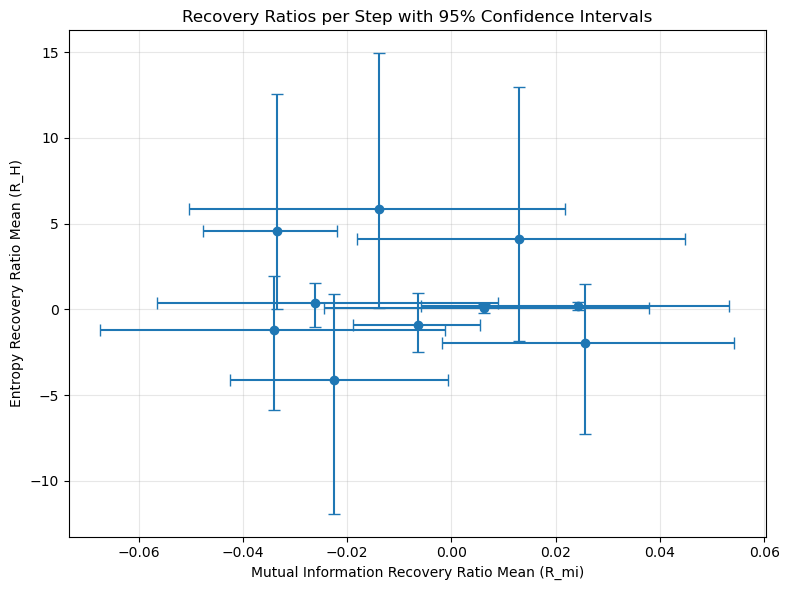

In [101]:
import matplotlib.pyplot as plt

def plot_recovery_ratios(rr_df):
    """
    Scatter plot of R_H_mean (y-axis) vs R_mi_mean (x-axis) with error bars for CIs.
    """
    plt.figure(figsize=(8, 6))
    # Plot error bars
    plt.errorbar(
        rr_df['R_mi_mean'], rr_df['R_H_mean'],
        xerr=[rr_df['R_mi_mean'] - rr_df['R_mi_CI_lower'], rr_df['R_mi_CI_upper'] - rr_df['R_mi_mean']],
        yerr=[rr_df['R_H_mean'] - rr_df['R_H_CI_lower'], rr_df['R_H_CI_upper'] - rr_df['R_H_mean']],
        fmt='o', capsize=4, label='Steps'
    )
    # Annotate each point with step number
    #for i, row in rr_df.iterrows():
    #    plt.annotate(str(row['step']), (row['R_mi_mean'], row['R_H_mean']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
    plt.xlabel('Mutual Information Recovery Ratio Mean (R_mi)')
    plt.ylabel('Entropy Recovery Ratio Mean (R_H)')
    plt.title('Recovery Ratios per Step with 95% Confidence Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Example usage:
plot_recovery_ratios(rr_df)

In [99]:
rr_df['R_H_CI_width'] = rr_df['R_H_CI_upper'] - rr_df['R_H_CI_lower']
rr_df['R_mi_CI_width'] = rr_df['R_mi_CI_upper'] - rr_df['R_mi_CI_lower']

# Example: select points where both CI widths are below the median (or set your own threshold)
threshold_H = rr_df['R_H_CI_width'].median()
threshold_mi = rr_df['R_mi_CI_width'].median()

filtered_rr_df = rr_df[
    (rr_df['R_H_CI_width'] < threshold_H) &
    (rr_df['R_mi_CI_width'] < threshold_mi)
]

# Now filtered_rr_df contains only the steps with "tight" CIs
display(filtered_rr_df)

,step,R_H_mean,R_H_CI_lower,R_H_CI_upper,R_mi_mean,R_mi_CI_lower,R_mi_CI_upper,R_H_cv,R_mi_cv,R_H_CI_width,R_mi_CI_width
3,3,-0.886265,-2.464271,0.942116,-0.006516,-0.018892,0.005424,NaN,NaN,3.406387,0.024316
9,9,0.197257,-0.043796,0.427533,0.024359,-0.005848,0.053134,NaN,NaN,0.471329,0.058982


(-10.0, 15.0)

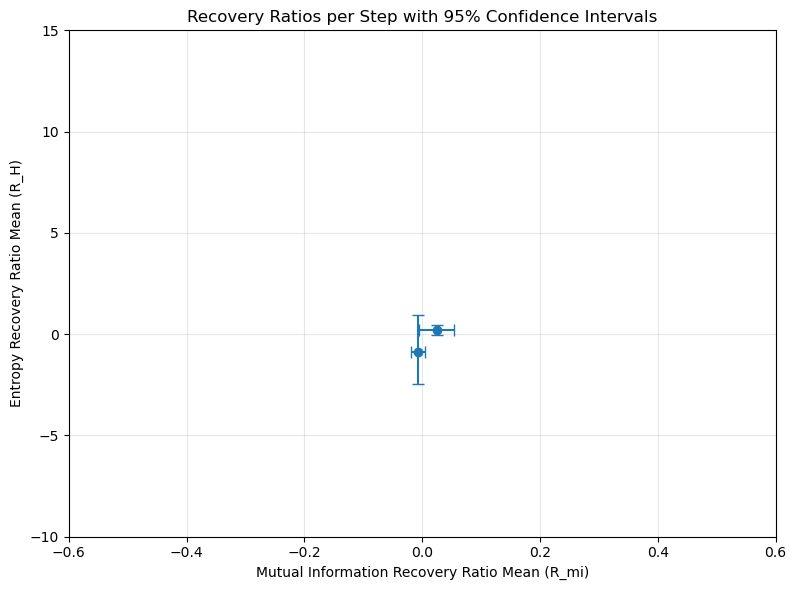

In [102]:
plot_recovery_ratios(filtered_rr_df)
plt.xlim(-0.6, 0.6)
plt.ylim(-10, 15)